In [27]:
import tszpower
import jax
import jax.numpy as jnp
import numpy as np
import blackjax
from datetime import date
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from getdist import MCSamples
import candl
import candl.interface
import candl.tools
import candl.plots
import candl.data
from getdist import plots, MCSamples
from classy_sz import Class as Class_sz

In [28]:
# Define your parameter dictionaries.
cosmo_params = {
    "omega_b": 0.0225,
    "omega_cdm": 0.118,
    "H0": 71.,
    # "tau_reio": 0.06,
    "ln10_10A_s": 3.05321,
    "n_s": 0.96,
    "B": 1.41,
}

nuisance_params = {
    "A_cib": 0.66,
    "A_ir": 2.04,
    "A_rs": 0.0004,
}

# Combine parameters (here we define the order explicitly).
pars_for_min = list(cosmo_params.keys()) + list(nuisance_params.keys())

# Example of an all-parameter dictionary (could be used as reference).
all_params = {
    "omega_b": 0.0225,
    "omega_cdm": 0.116,
    "H0": 71.,
    # "tau_reio": 0.06,
    "ln10_10A_s": 3.055,
    "n_s": 0.96,
    "B": 1.4,
    "A_cib": 0.66,
    "A_ir": 2.04,
    "A_rs": 0.0004,
}

In [29]:
# Print the log-likelihood for the dictionary input (as before).
loglike = tszpower.likelihood(all_params)
print("Log-likelihood:", loglike)

Log-likelihood: -80.30444798896737


In [30]:
def loglike_dict(params):
    return tszpower.likelihood(params)

In [31]:
# Wrap the likelihood function to accept a vector input.
def loglike_vec(input_vec):
    """
    Convert a vector of parameters (in the order given by `pars_for_min`) into a
    dictionary, optionally transform them from normalized units, and then evaluate
    the log-likelihood.
    """
    # Convert the vector to a dictionary using the predefined order.
    param_dict = {pars_for_min[i]: input_vec[i] for i in range(len(pars_for_min))}
    # print(param_dict)
    
    # Evaluate the log-likelihood with the non-normalized parameter dictionary.
    return tszpower.likelihood(param_dict)

In [32]:
input = {
    "omega_b": 0.0225,
    "omega_cdm": 0.12,
    "H0": 69.,
    # "tau_reio": 0.06,
    "ln10_10A_s": 3.1,
    "n_s": 0.955,
    "B": 1.5,
    "A_cib": 1.8,
    "A_ir": 0.2,
    "A_rs": 0.2,
}
# mass_matrix = np.loadtxt("tszpower_chain_full.covmat")
# inv_mass_matrix = np.linalg.inv(mass_matrix)

In [33]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state
    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    print(states)
    return states

In [ ]:
rng_key = jax.random.PRNGKey(int(date.today().strftime("%Y%m%d")))
nuts = blackjax.nuts(loglike_dict, step_size=0.0001, inverse_mass_matrix=jnp.ones(len(pars_for_min)))
step = nuts.step
initial_state = nuts.init(input)
states = inference_loop(rng_key,
                        nuts.step,
                        initial_state,
                        50)# Number of desired samples

In [ ]:
NUTS_samples = states.position

Text(0, 0.5, 'omega_cdm')

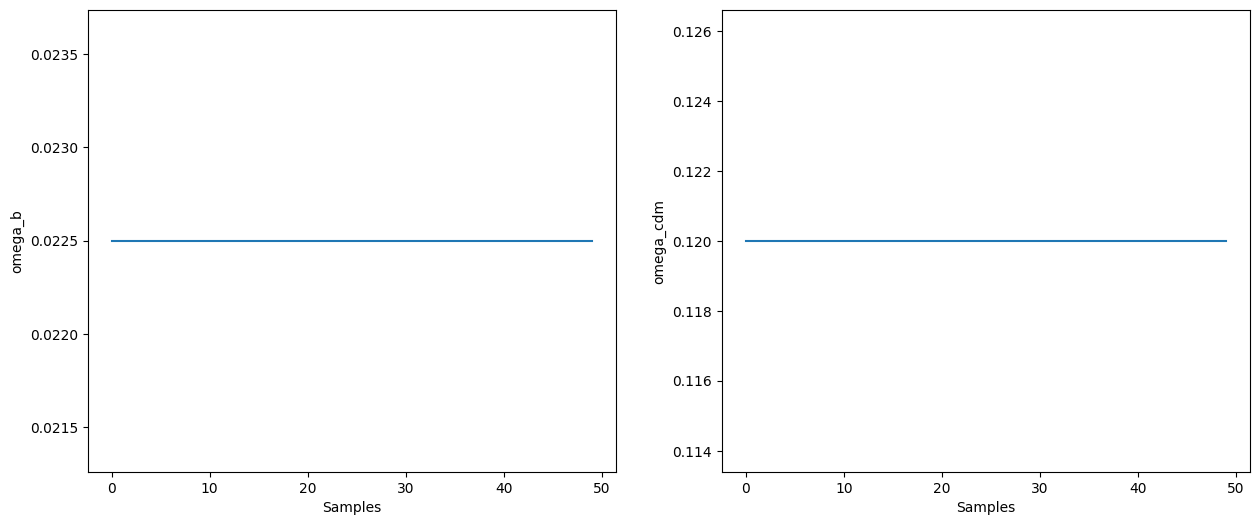

In [ ]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(NUTS_samples["omega_b"], label="omega_b")
ax.set_xlabel("Samples")
ax.set_ylabel("omega_b")

ax1.plot(NUTS_samples["omega_cdm"], label="omega_cdm")
ax1.set_xlabel("Samples")
ax1.set_ylabel("omega_cdm")

In [ ]:
# Extract parameter names
param_names = list(NUTS_samples.keys())  # ["A_cib", "A_ir", "omega_b", ...]

# Convert dictionary values to an array (each key contains a 1D array of samples)
samples_array = np.column_stack([NUTS_samples[param] for param in param_names])
# print(samples_array)
# Now create MCSamples object correctly
gd_samples_NUTS = MCSamples(
    samples=samples_array,
    names=param_names,
    labels=[candl.plots.PAR_LABEL_DICT[p] if p in candl.plots.PAR_LABEL_DICT else p for p in param_names],
    label='BlackJAX NUTS'
)
# Set log-likelihoods to zero (since BlackJAX doesn't return logl)
gd_samples_NUTS.loglikes = np.zeros(samples_array.shape[0])
# print(gd_samples_NUTS.loglikes.shape)

KeyError: 'omega_b'

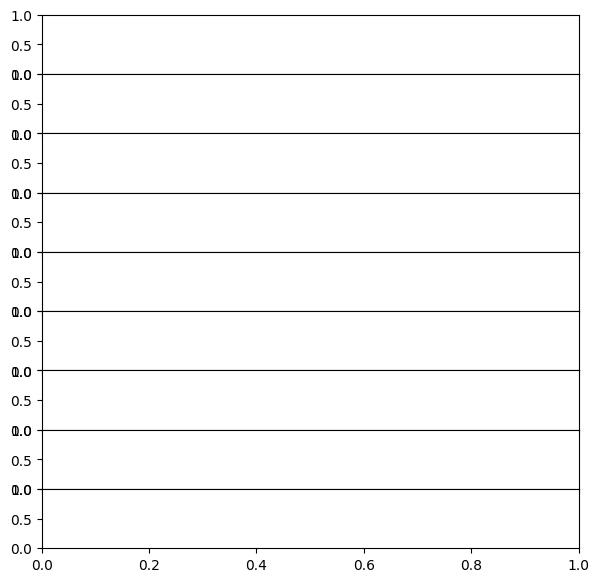

In [ ]:
fig, ax = candl.plots.plot_mcmc_chain_steps(
    gd_samples_NUTS,
    list(all_params.keys()),
    bf_point=None,  # Ensure it's explicitly set to None
    pars_in_cov=pars_for_min,
    show_logl=False
)


In [ ]:
%%time
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,
}

# initialize computation
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':' ',
'jax': 1,
})
classy_sz.compute_class_szfast()

CPU times: user 27.3 ms, sys: 12.3 ms, total: 39.6 ms
Wall time: 13.5 ms


In [ ]:
# ----- Adding Derived Parameters -----
# Get the parameters in a structured object (attributes correspond to parameter names)
p = gd_samples_NUTS.getParams()

# 1. Compute σ₈ for each sample from 'ln10_10A_s'
sigma8_values = []
for i in range(len(p.ln10_10A_s)):
    logA = p.ln10_10A_s[i]
    omega_cdm = p.omega_cdm[i]
    omega_b = p.omega_b[i]
    H0 = p.H0[i]
    n_s = p.n_s[i]
    cosmo_params = {
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'H0': H0,
        'ln10^{10}A_s': logA,
        'n_s': n_s,
    }

    A_s_dict = cosmo_params
    sigma8 = classy_sz.get_sigma8_and_der(params_values_dict=A_s_dict)[1]  # Compute sigma8
    sigma8_values.append(sigma8)
sigma8_values = np.array(sigma8_values)
gd_samples_NUTS.addDerived(sigma8_values, name='sigma8', label=r'$\sigma_8$')

# 2. Compute ln(1/A_rs)
ln_1_A_rs = np.log(1.0 / p.A_rs)
gd_samples_NUTS.addDerived(ln_1_A_rs, name='ln_1_A_rs', label=r'$\ln(1/A_{\mathrm{rs}})$')

# 3. Compute h, Ωₘ and the derived parameter F:
h = p.H0 / 100.0           # h = H0/100
omega_b = 0.0224           # fixed baryon density
Omega_m = (p.omega_cdm + omega_b) / h**2  # total matter density
F_values = sigma8_values * (Omega_m / p.B) ** 0.40 * h ** -0.21
gd_samples_NUTS.addDerived(F_values, name='F', label=r'$F = \sigma_8 (\Omega_m/B)^{0.40} h^{-0.21}$')

# Force GetDist to update its internal statistics and recognize the new parameters
gd_samples_NUTS.updateBaseStatistics()

print("Derived parameters added successfully.")


Derived parameters added successfully.


In [ ]:
# ----- Plotting the Derived Parameters -----
# Define the list of parameters you wish to plot (derived and base)
params_to_plot = ['F', 'A_cib', 'A_ir', 'ln_1_A_rs']

# Create a subplot plotter from GetDist
g = plots.get_subplot_plotter()
g.triangle_plot(gd_samples_NUTS, params_to_plot, filled=True)

# (Optional) Adjust axis limits for clarity
g.subplots[1, 1].set_xlim(0, 1)      # e.g., for 'A_cib'
g.subplots[2, 2].set_xlim(1.5, 2.5)    # e.g., for 'A_ir'
g.subplots[3, 3].set_xlim(-1.5, 6)     # e.g., for 'ln_1_A_rs'

# Show the plot
plt.show()


ValueError: 
$$F = \sigma_8 (\Omega_m/B)^{0.40} h^{-0.21}$$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

Error in callback <function _draw_all_if_interactive at 0x34167c680> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
$$F = \sigma_8 (\Omega_m/B)^{0.40} h^{-0.21}$$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$$F = \sigma_8 (\Omega_m/B)^{0.40} h^{-0.21}$$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 800x800 with 10 Axes>